## Introduction

In this notebook, I load compound metadata from the Probes & Drugs (ECBD) database, including:
- compound identifiers and SMILES strings,
- MoA annotations,
- target associations,
- binary flags (e.g. approval status, PAINS).

The goal is to merge these sources into a single compound-level dataframe for downstream modeling. I also perform basic analysis of class distribution and data completeness.

In [1]:
import numpy as np
import pandas as pd
from collections import Counter

from datetime import date

from matplotlib import pyplot as plt

In [2]:
# paths to data
ecbd_path = "ecbd/"
save_path = "result/"

## Preparing P&D data

Load P&D compounds dataset with EOS ids and merge it with ECBD targets dataset

In [3]:
# The file contains 2,464 connections that were tested in ECBD and mapped to EOS ID
df_compounds_eos = pd.read_excel(ecbd_path + "pd_export_01_2025_2464_compounds_standardized.xlsx")
df_compounds_eos

,EOS,pdid,name,smiles,inchi,inchikey,probe,experimental probe,calculated probe,available,...,hbd,rb,rc,arc,logp,tpsa,fcsp3,ncc,lrs,qed
0,EOS101163,PD000002,I-BRD9,CCn1cc(-c2cccc(C(F)(F)F)c2)c2sc(C(=N)NC3CCS(=O...,InChI=1S/C22H22F3N3O3S2/c1-2-28-12-17(13-4-3-5...,WRUWGLUCNBMGPS-UHFFFAOYSA-N,1.0,1.0,1.0,1,...,2.0,4.0,4.0,3.0,4.26,92.02,0.36,0.0,6.0,0.42
1,EOS101593,PD000003,UNC0638,COc1cc2c(NC3CCN(C(C)C)CC3)nc(C3CCCCC3)nc2cc1OC...,InChI=1S/C30H47N5O2/c1-22(2)35-17-12-24(13-18-...,QOECJCJVIMVJGX-UHFFFAOYSA-N,1.0,1.0,1.0,1,...,1.0,10.0,5.0,2.0,5.84,62.75,0.73,0.0,6.0,0.40
2,EOS101154,PD000005,UNC1215,O=C(c1ccc(C(=O)N2CCC(N3CCCC3)CC2)c(Nc2ccccc2)c...,InChI=1S/C32H43N5O2/c38-31(36-20-12-27(13-21-3...,PQOOIERVZAXHBP-UHFFFAOYSA-N,1.0,1.0,1.0,1,...,1.0,6.0,6.0,2.0,4.83,59.13,0.56,0.0,6.0,0.58
3,EOS101601,PD000007,IOX1,O=C(O)c1ccc(O)c2ncccc12,InChI=1S/C10H7NO3/c12-8-4-3-7(10(13)14)6-2-1-5...,JGRPKOGHYBAVMW-UHFFFAOYSA-N,1.0,1.0,NaN,1,...,2.0,1.0,2.0,2.0,1.64,70.42,0.00,0.0,6.0,0.71
4,EOS101116,PD000008,IOX2,O=C(O)CNC(=O)c1c(O)c2ccccc2n(Cc2ccccc2)c1=O,InChI=1S/C19H16N2O5/c22-15(23)10-20-18(25)16-1...,CAOSCCRYLYQBES-UHFFFAOYSA-N,1.0,1.0,NaN,1,...,3.0,5.0,3.0,3.0,1.57,108.63,0.11,0.0,6.0,0.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2459,EOS102392,PD164271,PD164271,N#CCc1ccccn1,"InChI=1S/C7H6N2/c8-5-4-7-3-1-2-6-9-7/h1-3,6H,4H2",UKVQBONVSSLJBB-UHFFFAOYSA-N,NaN,NaN,NaN,1,...,0.0,1.0,1.0,1.0,1.15,36.68,0.14,0.0,6.0,0.55
2460,EOS102394,PD164272,ALPHA-HEXACHLOROCYCLOHEXANE,Cl[C@H]1[C@H](Cl)[C@H](Cl)[C@@H](Cl)[C@H](Cl)[...,InChI=1S/C6H6Cl6/c7-1-2(8)4(10)6(12)5(11)3(1)9...,JLYXXMFPNIAWKQ-LKPKBOIGSA-N,NaN,NaN,NaN,1,...,0.0,0.0,1.0,0.0,3.64,0.00,1.00,0.0,6.0,0.60
2461,EOS102396,PD164274,PD164274,O=C(O)/C=C1/CCCc2ccccc2[C@@H]1O,InChI=1S/C13H14O3/c14-12(15)8-10-6-3-5-9-4-1-2...,UADPGHINQMWEAG-CHOZFAJLSA-N,NaN,NaN,NaN,1,...,2.0,1.0,2.0,1.0,2.07,57.53,0.31,1.0,7.0,0.56
2462,EOS102400,PD164275,PD164275,CC1CCC2C(=O)OC(=O)C2C1,InChI=1S/C9H12O3/c1-5-2-3-6-7(4-5)9(11)12-8(6)...,FKBMTBAXDISZGN-UHFFFAOYSA-N,NaN,NaN,NaN,1,...,0.0,0.0,2.0,0.0,1.12,43.37,0.78,3.0,6.0,0.40


In [4]:
df_compounds_eos['pdid'].unique().shape[0]

2464

In [5]:
df_compounds_eos['EOS'].unique().shape[0]

2464

P&D compounds dataset contains 2464 chemical compounds. They all has unique EOS ID.

Now we load P&D targets dataset and perform some analysis:

In [6]:
# Load tarets dataset from ecbd
df_targets = pd.read_csv(ecbd_path + 'pd_export_01_2025_targets_standardized.csv')
df_targets

/var/folders/h8/rf2xmj_n1_bc5sm335c9__zr0000gn/T/ipykernel_39157/2492569512.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_targets = pd.read_csv(ecbd_path + 'pd_export_01_2025_targets_standardized.csv')


,pdid,name,target_name,gene_name,target_type,moa,human,activity_biochemical,activity_cell,probe,...,Reactome [LEVEL 3],Reactome [LEVEL 4],Reactome [LEVEL 5],Reactome [LEVEL 6],Reactome [LEVEL 7],Reactome [LEVEL 8],Reactome [LEVEL 9],Reactome [LEVEL 10],Reactome [LEVEL 11],Reactome [LEVEL 12]
0,PD000001,BAZ2-ICR,Bromodomain adjacent to zinc finger domain pro...,BAZ2A,single protein,inhibitor,1,6.96,NaN,1.0,...,Negative epigenetic regulation of rRNA expression,NoRC negatively regulates rRNA expression,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PD000001,BAZ2-ICR,Bromodomain adjacent to zinc finger domain pro...,BAZ2B,single protein,inhibitor,1,6.77,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PD000001,BAZ2-ICR,Chromatin remodeling regulator CECR2,CECR2,single protein,NaN,1,5.81,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PD000001,BAZ2-ICR,Sodium channel protein type 2 subunit alpha,SCN2A,single protein,NaN,1,5.18,NaN,0.0,...,Axon guidance,L1CAM interactions,Interaction between L1 and Ankyrins,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PD000002,I-BRD9,Bromodomain-containing protein 4,BRD4,single protein,NaN,1,5.12,NaN,0.0,...,Viral Infection Pathways,SARS-CoV Infections,Potential therapeutics for SARS,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226209,PD216709,CHEMBL1528814,Nuclear receptor ROR-gamma,RORC,single protein,NaN,0,5.25,NaN,0.0,...,Generic Transcription Pathway,Transcriptional regulation by RUNX3,RUNX3 Regulates Immune Response and Cell Migra...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
226210,PD216709,CHEMBL1528814,Fructose-bisphosphate aldolase,FBA,single protein,NaN,0,4.80,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
226211,PD216709,CHEMBL1528814,Voltage-dependent N-type calcium channel subun...,CACNA1B,single protein,NaN,1,4.88,NaN,0.0,...,Presynaptic depolarization and calcium channel...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
226212,PD216709,CHEMBL1528814,Protein FosB,FOSB,single protein,NaN,0,NaN,4.54,0.0,...,Signaling by NTRKs,Signaling by NTRK1 (TRKA),Nuclear Events (kinase and transcription facto...,NGF-stimulated transcription,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df_targets['pdid'].unique().shape[0]

60034

We have many compounds with the same pdid, but different targets

In [8]:
df_targets['moa'].value_counts()

inhibitor                             23375
antagonist                             4562
agonist                                4143
blocker                                 585
activator                               546
                                      ...  
negative modulator;releasing agent        1
substrate;agonist                         1
modulator;inhibitor;agonist               1
antagonist;potentiator                    1
modulator;potentiator;activator           1
Name: moa, Length: 144, dtype: int64

Column `moa` is our target column. It contains mechanism of action type. There can be several types in one line, in this case the types are separated by semicolons.

We will transform `moa` into list. Also we will group by `pdid`

In [9]:
# split the 'moa' column into a list of unique values
df_targets['moa_list'] = df_targets['moa'].fillna('').apply(
    lambda x: list(set(s.strip() for s in x.split(';') if s.strip()))
)

# Group by 'pdid' and aggregate the 'moa_list' column
df_targets_grouped = df_targets.groupby("pdid").agg({
    "moa_list": lambda lists: list(set(sum(lists, [])))
}).reset_index()
df_targets_grouped

,pdid,moa_list
0,PD000001,[inhibitor]
1,PD000002,"[binding agent, antagonist]"
2,PD000003,[inhibitor]
3,PD000004,"[inhibitor, antagonist]"
4,PD000005,"[inhibitor, agonist]"
...,...,...
60029,PD216705,[]
60030,PD216706,[]
60031,PD216707,[]
60032,PD216708,[]


In [10]:
# Lets count the number of unique MOAs
df_targets_moa_counter = Counter([moa.strip() for sublist in df_targets['moa_list'] for moa in sublist if moa.strip()])

df_targets_moa_counts = pd.DataFrame(df_targets_moa_counter.items(), columns=['moa', 'count']).sort_values(by='count', ascending=False)
df_targets_moa_counts

,moa,count
0,inhibitor,23699
2,antagonist,4989
3,agonist,4439
6,blocker,660
11,activator,602
10,partial agonist,592
4,allosteric modulator,562
1,binding agent,539
14,substrate,220
9,inverse agonist,208


In [11]:
# Count the number of unique MOAs
count_all_classes = df_targets_moa_counts.aggregate({'count': ['sum']}).iloc[0, 0]
# Count of classet thats not inhibitors or antagonists or agonist
count_major_classes = df_targets_moa_counts[
  (df_targets_moa_counts['moa'] == 'inhibitor') | (df_targets_moa_counts['moa'] == 'antagonist') | (df_targets_moa_counts['moa'] == 'agonist')
].aggregate({'count': ['sum']}).iloc[0, 0]

print(f"Total number of unique classes: {count_all_classes}")
print(f"Total number of major classes (inhibitors or antagonists or agonist): {count_major_classes}")
print(f"Part of major classes: {(count_major_classes / count_all_classes):.2%}")

Total number of unique classes: 37814
Total number of major classes (inhibitors or antagonists or agonist): 33127
Part of major classes: 87.61%


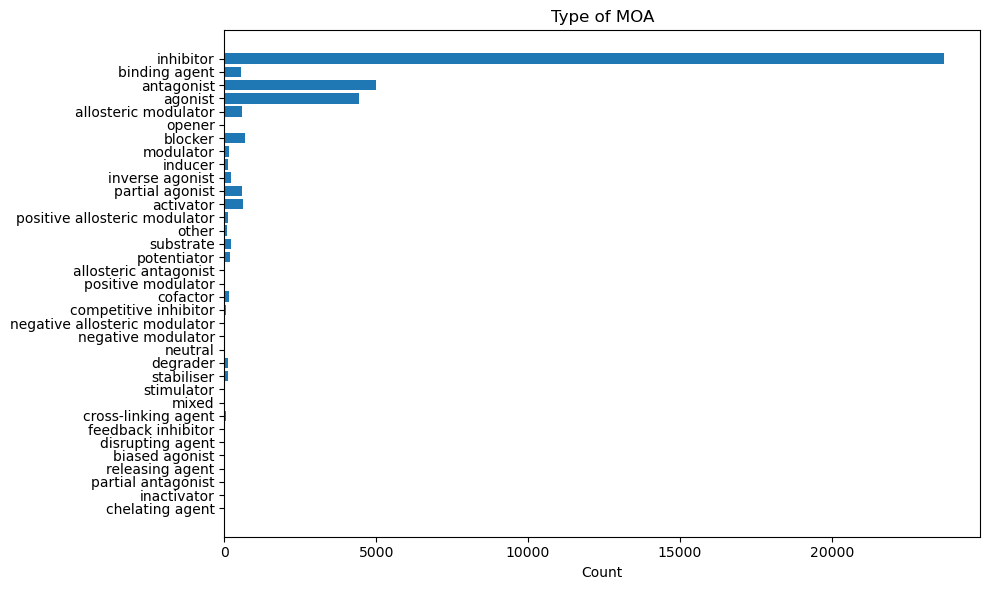

In [12]:
plt.figure(figsize=(10, 6))
plt.barh(list(df_targets_moa_counter.keys())[::-1], list(df_targets_moa_counter.values())[::-1])
plt.xlabel("Count")
plt.title("Type of MOA")
plt.tight_layout()
plt.show()

Here we can see huge disbalance of `moa` classes. `inhibitor` is dominant class (23699). `agonist` (4439) and `antagonist` (4989) are large enough classes for machine learning.

Probably we could think about grouping some classes together.

Now we ready to merge compounds with targets.

In [13]:
# Check the number of merged compounds
merge_result = df_compounds_eos.merge(df_targets_grouped, on='pdid', how="outer", indicator=True)
merge_result['_merge'].value_counts()

right_only    57669
both           2365
left_only        99
Name: _merge, dtype: int64

In [14]:
merge_result[merge_result['_merge'] == 'left_only']

,EOS,pdid,name,smiles,inchi,inchikey,probe,experimental probe,calculated probe,available,...,rc,arc,logp,tpsa,fcsp3,ncc,lrs,qed,moa_list,_merge
186,EOS102130,PD001637,AMINOPTERIN,Nc1nc(N)c2nc(CNc3ccc(C(=O)NC(CCC(=O)O)C(=O)O)c...,InChI=1S/C19H20N8O5/c20-15-14-16(27-19(21)26-1...,TVZGACDUOSZQKY-UHFFFAOYSA-N,NaN,NaN,NaN,1.0,...,3.0,3.0,0.24,219.33,0.21,1.0,6.0,0.26,NaN,left_only
190,EOS102232,PD001660,LEVONORGESTREL,C#C[C@]1(O)CCC2C3CCC4=CC(=O)CC[C@@H]4C3CC[C@@]...,InChI=1S/C21H28O2/c1-3-20-11-9-17-16-8-6-15(22...,WWYNJERNGUHSAO-RYHLCRTJSA-N,NaN,NaN,NaN,1.0,...,4.0,0.0,3.88,37.30,0.76,6.0,6.0,0.75,NaN,left_only
332,EOS102054,PD002921,PENICILLIN V,CC1(C)SC2C(NC(=O)COc3ccccc3)C(=O)N2C1C(=O)O,InChI=1S/C16H18N2O5S/c1-16(2)12(15(21)22)18-13...,BPLBGHOLXOTWMN-UHFFFAOYSA-N,NaN,NaN,NaN,1.0,...,3.0,1.0,0.70,95.94,0.44,3.0,6.0,0.76,NaN,left_only
340,EOS102447,PD002991,fluorometholone,CC(=O)C1(O)CCC2C3CC(C)C4=CC(=O)C=CC4(C)C3(F)C(...,"InChI=1S/C22H29FO4/c1-12-9-17-15-6-8-21(27,13(...",FAOZLTXFLGPHNG-UHFFFAOYSA-N,NaN,NaN,NaN,1.0,...,4.0,0.0,2.92,74.60,0.73,8.0,6.0,0.74,NaN,left_only
550,EOS101214,PD004223,Sch 1000,CC(C)[N@+]1(C)C2CC[C@H]1C[C@@H](OC(=O)C(CO)c1c...,InChI=1S/C20H30NO3/c1-14(2)21(3)16-9-10-17(21)...,OEXHQOGQTVQTAT-TYHZTFFYSA-N,NaN,NaN,NaN,1.0,...,3.0,1.0,2.85,46.53,0.65,5.0,6.0,0.67,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2459,EOS102392,PD164271,PD164271,N#CCc1ccccn1,"InChI=1S/C7H6N2/c8-5-4-7-3-1-2-6-9-7/h1-3,6H,4H2",UKVQBONVSSLJBB-UHFFFAOYSA-N,NaN,NaN,NaN,1.0,...,1.0,1.0,1.15,36.68,0.14,0.0,6.0,0.55,NaN,left_only
2460,EOS102394,PD164272,ALPHA-HEXACHLOROCYCLOHEXANE,Cl[C@H]1[C@H](Cl)[C@H](Cl)[C@@H](Cl)[C@H](Cl)[...,InChI=1S/C6H6Cl6/c7-1-2(8)4(10)6(12)5(11)3(1)9...,JLYXXMFPNIAWKQ-LKPKBOIGSA-N,NaN,NaN,NaN,1.0,...,1.0,0.0,3.64,0.00,1.00,0.0,6.0,0.60,NaN,left_only
2461,EOS102396,PD164274,PD164274,O=C(O)/C=C1/CCCc2ccccc2[C@@H]1O,InChI=1S/C13H14O3/c14-12(15)8-10-6-3-5-9-4-1-2...,UADPGHINQMWEAG-CHOZFAJLSA-N,NaN,NaN,NaN,1.0,...,2.0,1.0,2.07,57.53,0.31,1.0,7.0,0.56,NaN,left_only
2462,EOS102400,PD164275,PD164275,CC1CCC2C(=O)OC(=O)C2C1,InChI=1S/C9H12O3/c1-5-2-3-6-7(4-5)9(11)12-8(6)...,FKBMTBAXDISZGN-UHFFFAOYSA-N,NaN,NaN,NaN,1.0,...,2.0,0.0,1.12,43.37,0.78,3.0,6.0,0.40,NaN,left_only


Interesting that there are no target data for 99 chemical compounds. It seems that in this case we assume that it has an empty `moa` list.

In [15]:
df_ecbd = df_compounds_eos.merge(df_targets_grouped, on='pdid', how='left')
df_ecbd

,EOS,pdid,name,smiles,inchi,inchikey,probe,experimental probe,calculated probe,available,...,rb,rc,arc,logp,tpsa,fcsp3,ncc,lrs,qed,moa_list
0,EOS101163,PD000002,I-BRD9,CCn1cc(-c2cccc(C(F)(F)F)c2)c2sc(C(=N)NC3CCS(=O...,InChI=1S/C22H22F3N3O3S2/c1-2-28-12-17(13-4-3-5...,WRUWGLUCNBMGPS-UHFFFAOYSA-N,1.0,1.0,1.0,1,...,4.0,4.0,3.0,4.26,92.02,0.36,0.0,6.0,0.42,"[binding agent, antagonist]"
1,EOS101593,PD000003,UNC0638,COc1cc2c(NC3CCN(C(C)C)CC3)nc(C3CCCCC3)nc2cc1OC...,InChI=1S/C30H47N5O2/c1-22(2)35-17-12-24(13-18-...,QOECJCJVIMVJGX-UHFFFAOYSA-N,1.0,1.0,1.0,1,...,10.0,5.0,2.0,5.84,62.75,0.73,0.0,6.0,0.40,[inhibitor]
2,EOS101154,PD000005,UNC1215,O=C(c1ccc(C(=O)N2CCC(N3CCCC3)CC2)c(Nc2ccccc2)c...,InChI=1S/C32H43N5O2/c38-31(36-20-12-27(13-21-3...,PQOOIERVZAXHBP-UHFFFAOYSA-N,1.0,1.0,1.0,1,...,6.0,6.0,2.0,4.83,59.13,0.56,0.0,6.0,0.58,"[inhibitor, agonist]"
3,EOS101601,PD000007,IOX1,O=C(O)c1ccc(O)c2ncccc12,InChI=1S/C10H7NO3/c12-8-4-3-7(10(13)14)6-2-1-5...,JGRPKOGHYBAVMW-UHFFFAOYSA-N,1.0,1.0,NaN,1,...,1.0,2.0,2.0,1.64,70.42,0.00,0.0,6.0,0.71,[inhibitor]
4,EOS101116,PD000008,IOX2,O=C(O)CNC(=O)c1c(O)c2ccccc2n(Cc2ccccc2)c1=O,InChI=1S/C19H16N2O5/c22-15(23)10-20-18(25)16-1...,CAOSCCRYLYQBES-UHFFFAOYSA-N,1.0,1.0,NaN,1,...,5.0,3.0,3.0,1.57,108.63,0.11,0.0,6.0,0.65,[inhibitor]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2459,EOS102392,PD164271,PD164271,N#CCc1ccccn1,"InChI=1S/C7H6N2/c8-5-4-7-3-1-2-6-9-7/h1-3,6H,4H2",UKVQBONVSSLJBB-UHFFFAOYSA-N,NaN,NaN,NaN,1,...,1.0,1.0,1.0,1.15,36.68,0.14,0.0,6.0,0.55,NaN
2460,EOS102394,PD164272,ALPHA-HEXACHLOROCYCLOHEXANE,Cl[C@H]1[C@H](Cl)[C@H](Cl)[C@@H](Cl)[C@H](Cl)[...,InChI=1S/C6H6Cl6/c7-1-2(8)4(10)6(12)5(11)3(1)9...,JLYXXMFPNIAWKQ-LKPKBOIGSA-N,NaN,NaN,NaN,1,...,0.0,1.0,0.0,3.64,0.00,1.00,0.0,6.0,0.60,NaN
2461,EOS102396,PD164274,PD164274,O=C(O)/C=C1/CCCc2ccccc2[C@@H]1O,InChI=1S/C13H14O3/c14-12(15)8-10-6-3-5-9-4-1-2...,UADPGHINQMWEAG-CHOZFAJLSA-N,NaN,NaN,NaN,1,...,1.0,2.0,1.0,2.07,57.53,0.31,1.0,7.0,0.56,NaN
2462,EOS102400,PD164275,PD164275,CC1CCC2C(=O)OC(=O)C2C1,InChI=1S/C9H12O3/c1-5-2-3-6-7(4-5)9(11)12-8(6)...,FKBMTBAXDISZGN-UHFFFAOYSA-N,NaN,NaN,NaN,1,...,0.0,2.0,0.0,1.12,43.37,0.78,3.0,6.0,0.40,NaN


In [16]:
df_ecbd['moa_list'].isna().sum()

99

In [17]:
# Lets replace the NaN values with empty lists
df_ecbd['moa_list'] = df_ecbd['moa_list'].apply(lambda x: x if isinstance(x, list) else [])

In [18]:
df_ecbd['moa_list'].isna().sum()

0

Now we can count class balances one more time, but for our smaller dataset (2 464 rows )

In [19]:
df_ecbd_moa_counter = Counter([moa.strip() for sublist in df_ecbd['moa_list'] for moa in sublist if moa.strip()])

df_ecbd_moa_counts = pd.DataFrame(df_ecbd_moa_counter.items(), columns=['moa', 'count']).sort_values(by='count', ascending=False)
df_ecbd_moa_counts

,moa,count
2,inhibitor,1070
1,antagonist,328
3,agonist,321
7,blocker,83
9,partial agonist,64
10,activator,57
0,binding agent,54
4,allosteric modulator,43
11,inverse agonist,31
12,other,22


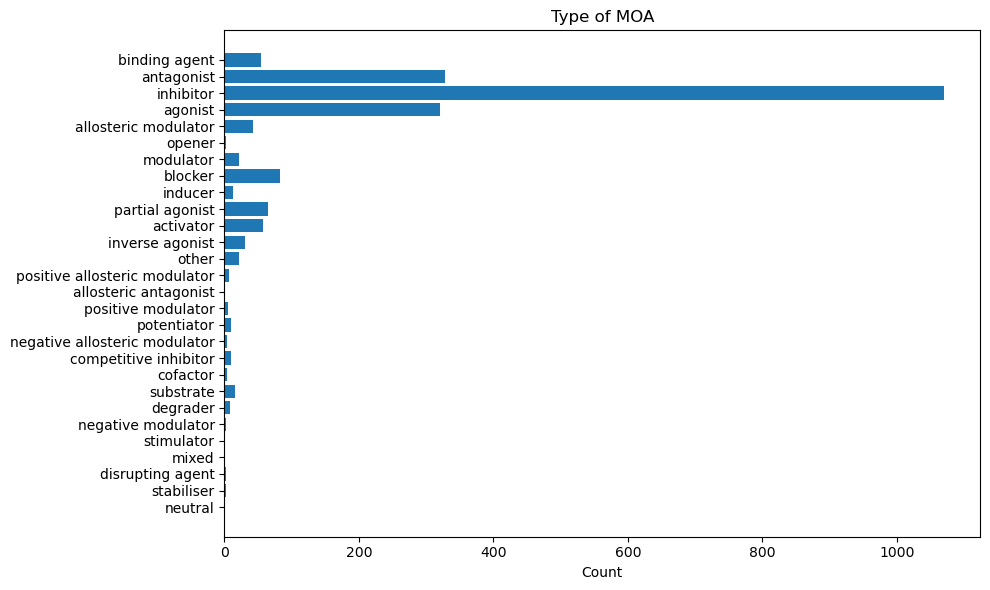

In [20]:
plt.figure(figsize=(10, 6))
plt.barh(list(df_ecbd_moa_counter.keys())[::-1], list(df_ecbd_moa_counter.values())[::-1])
plt.xlabel("Count")
plt.title("Type of MOA")
plt.tight_layout()
plt.show()

The same picture but on smaller scale.

Now we do the same thing with another column with classes - `Drug Status`

In [21]:
# Rename the columns to be more readable
df_ecbd.rename(columns={'Drug Status': 'drug_status'}, inplace=True)
# split the column into a list of unique values
df_ecbd['drug_status_list'] = df_ecbd['drug_status'].fillna('').astype(str).apply(
    lambda x: list(set(s.strip() for s in x.split(';') if s.strip()))
)
# count the number of unique drug status
drug_status_counts = Counter([drug_status.strip() for sublist in df_ecbd['drug_status_list'] for drug_status in sublist if drug_status.strip()])

drug_status_df = pd.DataFrame(drug_status_counts.items(), columns=['Drug Status', 'count']).sort_values(by='count', ascending=False)
drug_status_df

,Drug Status,count
0,investigational,804
1,approved,692
3,experimental,190
2,withdrawn,122
4,vet_approved,68
5,nutraceutical,13


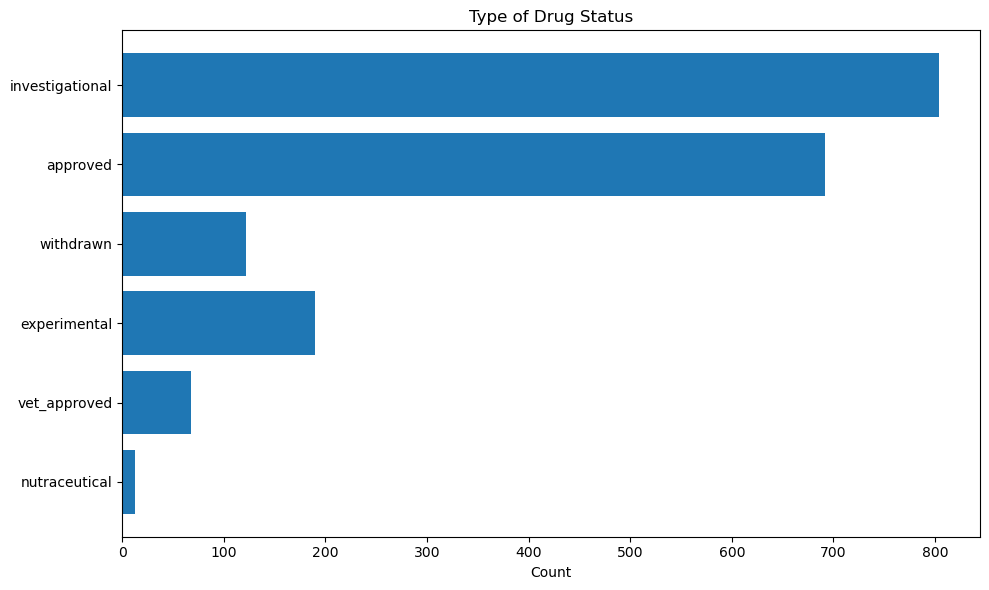

In [22]:
plt.figure(figsize=(10, 6))
plt.barh(list(drug_status_counts.keys())[::-1], list(drug_status_counts.values())[::-1])
plt.xlabel("Count")
plt.title("Type of Drug Status")
plt.tight_layout()
plt.show()

This data should be useful during machine learning.

We can use MultiLabelBinarizer to one-hot encode the 'moa_list' column. 
This transforms each unique MoA into a separate binary feature, allowing us to use the data effectively in machine learning models.

In [23]:
from sklearn.preprocessing import MultiLabelBinarizer

# create Binarizer
mlb_moa = MultiLabelBinarizer()
# Encoding the MOA list
moa_encoded = pd.DataFrame(
    mlb_moa.fit_transform(df_ecbd['moa_list']),
    columns=[f'moa_{cls}' for cls in mlb_moa.classes_],
    index=df_ecbd.index
)
# Drop the original 'moa_list' column
df_ecbd.drop(columns=['moa_list'], inplace=True)
# Concatenate the encoded columns with the original DataFrame
df_ecbd = pd.concat([df_ecbd, moa_encoded], axis=1)
df_ecbd

,EOS,pdid,name,smiles,inchi,inchikey,probe,experimental probe,calculated probe,available,...,moa_neutral,moa_opener,moa_other,moa_partial agonist,moa_positive allosteric modulator,moa_positive modulator,moa_potentiator,moa_stabiliser,moa_stimulator,moa_substrate
0,EOS101163,PD000002,I-BRD9,CCn1cc(-c2cccc(C(F)(F)F)c2)c2sc(C(=N)NC3CCS(=O...,InChI=1S/C22H22F3N3O3S2/c1-2-28-12-17(13-4-3-5...,WRUWGLUCNBMGPS-UHFFFAOYSA-N,1.0,1.0,1.0,1,...,0,0,0,0,0,0,0,0,0,0
1,EOS101593,PD000003,UNC0638,COc1cc2c(NC3CCN(C(C)C)CC3)nc(C3CCCCC3)nc2cc1OC...,InChI=1S/C30H47N5O2/c1-22(2)35-17-12-24(13-18-...,QOECJCJVIMVJGX-UHFFFAOYSA-N,1.0,1.0,1.0,1,...,0,0,0,0,0,0,0,0,0,0
2,EOS101154,PD000005,UNC1215,O=C(c1ccc(C(=O)N2CCC(N3CCCC3)CC2)c(Nc2ccccc2)c...,InChI=1S/C32H43N5O2/c38-31(36-20-12-27(13-21-3...,PQOOIERVZAXHBP-UHFFFAOYSA-N,1.0,1.0,1.0,1,...,0,0,0,0,0,0,0,0,0,0
3,EOS101601,PD000007,IOX1,O=C(O)c1ccc(O)c2ncccc12,InChI=1S/C10H7NO3/c12-8-4-3-7(10(13)14)6-2-1-5...,JGRPKOGHYBAVMW-UHFFFAOYSA-N,1.0,1.0,NaN,1,...,0,0,0,0,0,0,0,0,0,0
4,EOS101116,PD000008,IOX2,O=C(O)CNC(=O)c1c(O)c2ccccc2n(Cc2ccccc2)c1=O,InChI=1S/C19H16N2O5/c22-15(23)10-20-18(25)16-1...,CAOSCCRYLYQBES-UHFFFAOYSA-N,1.0,1.0,NaN,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2459,EOS102392,PD164271,PD164271,N#CCc1ccccn1,"InChI=1S/C7H6N2/c8-5-4-7-3-1-2-6-9-7/h1-3,6H,4H2",UKVQBONVSSLJBB-UHFFFAOYSA-N,NaN,NaN,NaN,1,...,0,0,0,0,0,0,0,0,0,0
2460,EOS102394,PD164272,ALPHA-HEXACHLOROCYCLOHEXANE,Cl[C@H]1[C@H](Cl)[C@H](Cl)[C@@H](Cl)[C@H](Cl)[...,InChI=1S/C6H6Cl6/c7-1-2(8)4(10)6(12)5(11)3(1)9...,JLYXXMFPNIAWKQ-LKPKBOIGSA-N,NaN,NaN,NaN,1,...,0,0,0,0,0,0,0,0,0,0
2461,EOS102396,PD164274,PD164274,O=C(O)/C=C1/CCCc2ccccc2[C@@H]1O,InChI=1S/C13H14O3/c14-12(15)8-10-6-3-5-9-4-1-2...,UADPGHINQMWEAG-CHOZFAJLSA-N,NaN,NaN,NaN,1,...,0,0,0,0,0,0,0,0,0,0
2462,EOS102400,PD164275,PD164275,CC1CCC2C(=O)OC(=O)C2C1,InChI=1S/C9H12O3/c1-5-2-3-6-7(4-5)9(11)12-8(6)...,FKBMTBAXDISZGN-UHFFFAOYSA-N,NaN,NaN,NaN,1,...,0,0,0,0,0,0,0,0,0,0


Now we can do the same with column `drug_status_list`:

In [24]:
# create Binarizer
mlb_status = MultiLabelBinarizer()
# Encoding drug_status_list
status_encoded = pd.DataFrame(
    mlb_status.fit_transform(df_ecbd['drug_status_list']),
    columns=[f'drug_status_{cls}' for cls in mlb_status.classes_],
    index=df_ecbd.index
)
# Drop the original 'drug_status_list' column
df_ecbd.drop(columns=['drug_status_list'], inplace=True)
# Concatenate the encoded columns with the original DataFrame
df_ecbd = pd.concat([df_ecbd, status_encoded], axis=1)
df_ecbd

,EOS,pdid,name,smiles,inchi,inchikey,probe,experimental probe,calculated probe,available,...,moa_potentiator,moa_stabiliser,moa_stimulator,moa_substrate,drug_status_approved,drug_status_experimental,drug_status_investigational,drug_status_nutraceutical,drug_status_vet_approved,drug_status_withdrawn
0,EOS101163,PD000002,I-BRD9,CCn1cc(-c2cccc(C(F)(F)F)c2)c2sc(C(=N)NC3CCS(=O...,InChI=1S/C22H22F3N3O3S2/c1-2-28-12-17(13-4-3-5...,WRUWGLUCNBMGPS-UHFFFAOYSA-N,1.0,1.0,1.0,1,...,0,0,0,0,0,0,0,0,0,0
1,EOS101593,PD000003,UNC0638,COc1cc2c(NC3CCN(C(C)C)CC3)nc(C3CCCCC3)nc2cc1OC...,InChI=1S/C30H47N5O2/c1-22(2)35-17-12-24(13-18-...,QOECJCJVIMVJGX-UHFFFAOYSA-N,1.0,1.0,1.0,1,...,0,0,0,0,0,0,0,0,0,0
2,EOS101154,PD000005,UNC1215,O=C(c1ccc(C(=O)N2CCC(N3CCCC3)CC2)c(Nc2ccccc2)c...,InChI=1S/C32H43N5O2/c38-31(36-20-12-27(13-21-3...,PQOOIERVZAXHBP-UHFFFAOYSA-N,1.0,1.0,1.0,1,...,0,0,0,0,0,0,0,0,0,0
3,EOS101601,PD000007,IOX1,O=C(O)c1ccc(O)c2ncccc12,InChI=1S/C10H7NO3/c12-8-4-3-7(10(13)14)6-2-1-5...,JGRPKOGHYBAVMW-UHFFFAOYSA-N,1.0,1.0,NaN,1,...,0,0,0,0,0,0,0,0,0,0
4,EOS101116,PD000008,IOX2,O=C(O)CNC(=O)c1c(O)c2ccccc2n(Cc2ccccc2)c1=O,InChI=1S/C19H16N2O5/c22-15(23)10-20-18(25)16-1...,CAOSCCRYLYQBES-UHFFFAOYSA-N,1.0,1.0,NaN,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2459,EOS102392,PD164271,PD164271,N#CCc1ccccn1,"InChI=1S/C7H6N2/c8-5-4-7-3-1-2-6-9-7/h1-3,6H,4H2",UKVQBONVSSLJBB-UHFFFAOYSA-N,NaN,NaN,NaN,1,...,0,0,0,0,0,0,0,0,0,0
2460,EOS102394,PD164272,ALPHA-HEXACHLOROCYCLOHEXANE,Cl[C@H]1[C@H](Cl)[C@H](Cl)[C@@H](Cl)[C@H](Cl)[...,InChI=1S/C6H6Cl6/c7-1-2(8)4(10)6(12)5(11)3(1)9...,JLYXXMFPNIAWKQ-LKPKBOIGSA-N,NaN,NaN,NaN,1,...,0,0,0,0,0,0,0,0,0,0
2461,EOS102396,PD164274,PD164274,O=C(O)/C=C1/CCCc2ccccc2[C@@H]1O,InChI=1S/C13H14O3/c14-12(15)8-10-6-3-5-9-4-1-2...,UADPGHINQMWEAG-CHOZFAJLSA-N,NaN,NaN,NaN,1,...,0,0,0,0,0,0,0,0,0,0
2462,EOS102400,PD164275,PD164275,CC1CCC2C(=O)OC(=O)C2C1,InChI=1S/C9H12O3/c1-5-2-3-6-7(4-5)9(11)12-8(6)...,FKBMTBAXDISZGN-UHFFFAOYSA-N,NaN,NaN,NaN,1,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# Also transform the 'no. targets' column to int
df_ecbd['no. targets'] = df_ecbd['no. targets'].astype(int)

Let's investigate empty data:

In [26]:
# Count missing values
missing = df_ecbd.isna().sum()
missing_percent = (missing / len(df_ecbd)) * 100
df_missing = pd.DataFrame({
    'missing_count': missing,
    'missing_percent': missing_percent
}).sort_values(by='missing_percent', ascending=False)
# Display only the columns with missing values
df_missing[df_missing['missing_count'] > 0]

,missing_count,missing_percent
inorganic,2462,99.918831
Obsolete,2458,99.756494
PAINS Family C,2452,99.512987
PAINS Family B,2441,99.066558
biased GPCR ligand,2426,98.457792
PAINS Family A,2410,97.808442
Aggregator,2384,96.753247
Nuisance,2366,96.022727
covalent binder,2361,95.819805
P&D approved,2324,94.318182


We see that most of the gaps are in binary tags

In [27]:
df_ecbd['P&D approved'].value_counts()

1.0    140
Name: P&D approved, dtype: int64

As we can see, these columns have only one value - 1.0

We can fill empty values with zeros:

In [28]:
binary_flags = [
    'probe',                # chemical probe? 
    'experimental probe',   # experimentally validated probe?
    'calculated probe',     # theoretically predicted probe?
    'available',            # available?
    'approved drug',        # approved drug?
    'P&D approved',         # Probe & Drug approved?
    'covalent binder',      # compound binds to the target covalently?
    'biased GPCR ligand',   # biased GPCR ligand?
    'inorganic',            # contains inorganic atoms?
    'structural alert',     # contains dangerous or unstable chemical fragments?
    'PAINS Family A',       # belongs to PAINS? (frequent false positives)
    'PAINS Family B',       #
    'PAINS Family C',       # 
    'Aggregator',           # prone to aggregation?
    'Obsolete',             # obsolete? (no longer used in research)
    'Nuisance',             # considered a nuisance? (interfering or undesirable)
]

# Fill NaN values in binary columns with 0 and convert to int
for col in binary_flags:
    if col in df_ecbd.columns:
        df_ecbd[col] = df_ecbd[col].fillna(0).astype(int)

df_ecbd

,EOS,pdid,name,smiles,inchi,inchikey,probe,experimental probe,calculated probe,available,...,moa_potentiator,moa_stabiliser,moa_stimulator,moa_substrate,drug_status_approved,drug_status_experimental,drug_status_investigational,drug_status_nutraceutical,drug_status_vet_approved,drug_status_withdrawn
0,EOS101163,PD000002,I-BRD9,CCn1cc(-c2cccc(C(F)(F)F)c2)c2sc(C(=N)NC3CCS(=O...,InChI=1S/C22H22F3N3O3S2/c1-2-28-12-17(13-4-3-5...,WRUWGLUCNBMGPS-UHFFFAOYSA-N,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,EOS101593,PD000003,UNC0638,COc1cc2c(NC3CCN(C(C)C)CC3)nc(C3CCCCC3)nc2cc1OC...,InChI=1S/C30H47N5O2/c1-22(2)35-17-12-24(13-18-...,QOECJCJVIMVJGX-UHFFFAOYSA-N,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,EOS101154,PD000005,UNC1215,O=C(c1ccc(C(=O)N2CCC(N3CCCC3)CC2)c(Nc2ccccc2)c...,InChI=1S/C32H43N5O2/c38-31(36-20-12-27(13-21-3...,PQOOIERVZAXHBP-UHFFFAOYSA-N,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,EOS101601,PD000007,IOX1,O=C(O)c1ccc(O)c2ncccc12,InChI=1S/C10H7NO3/c12-8-4-3-7(10(13)14)6-2-1-5...,JGRPKOGHYBAVMW-UHFFFAOYSA-N,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,EOS101116,PD000008,IOX2,O=C(O)CNC(=O)c1c(O)c2ccccc2n(Cc2ccccc2)c1=O,InChI=1S/C19H16N2O5/c22-15(23)10-20-18(25)16-1...,CAOSCCRYLYQBES-UHFFFAOYSA-N,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2459,EOS102392,PD164271,PD164271,N#CCc1ccccn1,"InChI=1S/C7H6N2/c8-5-4-7-3-1-2-6-9-7/h1-3,6H,4H2",UKVQBONVSSLJBB-UHFFFAOYSA-N,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2460,EOS102394,PD164272,ALPHA-HEXACHLOROCYCLOHEXANE,Cl[C@H]1[C@H](Cl)[C@H](Cl)[C@@H](Cl)[C@H](Cl)[...,InChI=1S/C6H6Cl6/c7-1-2(8)4(10)6(12)5(11)3(1)9...,JLYXXMFPNIAWKQ-LKPKBOIGSA-N,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2461,EOS102396,PD164274,PD164274,O=C(O)/C=C1/CCCc2ccccc2[C@@H]1O,InChI=1S/C13H14O3/c14-12(15)8-10-6-3-5-9-4-1-2...,UADPGHINQMWEAG-CHOZFAJLSA-N,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2462,EOS102400,PD164275,PD164275,CC1CCC2C(=O)OC(=O)C2C1,InChI=1S/C9H12O3/c1-5-2-3-6-7(4-5)9(11)12-8(6)...,FKBMTBAXDISZGN-UHFFFAOYSA-N,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


We can also add a prefix for convenient calculation of columns with meta-data, since they will not participate in training:

In [29]:
metadata = [
    'EOS',          # Unique ECBD compound ID
    'pdid',         # Compound ID
    'name',         # Name of the drug or compound
    'smiles',       # SMILES string
    'inchi',        # InChI string
    'inchikey',     # Hashed InChI key
    'cas',          # CAS number — reference chemical identifier (semicolon-separated string array)
    'synonyms',     # Alternative names of the compound (semicolon-separated string array)
    'target_name',  # Full name of the target protein
    'gene_name'     # Gene symbol of the target
]

# Add prefix 'Metadata_' to metadata columns
df_ecbd = df_ecbd.rename(columns={col: f'Metadata_{col}' for col in metadata if col in df_ecbd.columns})
df_ecbd

,Metadata_EOS,Metadata_pdid,Metadata_name,Metadata_smiles,Metadata_inchi,Metadata_inchikey,probe,experimental probe,calculated probe,available,...,moa_potentiator,moa_stabiliser,moa_stimulator,moa_substrate,drug_status_approved,drug_status_experimental,drug_status_investigational,drug_status_nutraceutical,drug_status_vet_approved,drug_status_withdrawn
0,EOS101163,PD000002,I-BRD9,CCn1cc(-c2cccc(C(F)(F)F)c2)c2sc(C(=N)NC3CCS(=O...,InChI=1S/C22H22F3N3O3S2/c1-2-28-12-17(13-4-3-5...,WRUWGLUCNBMGPS-UHFFFAOYSA-N,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,EOS101593,PD000003,UNC0638,COc1cc2c(NC3CCN(C(C)C)CC3)nc(C3CCCCC3)nc2cc1OC...,InChI=1S/C30H47N5O2/c1-22(2)35-17-12-24(13-18-...,QOECJCJVIMVJGX-UHFFFAOYSA-N,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,EOS101154,PD000005,UNC1215,O=C(c1ccc(C(=O)N2CCC(N3CCCC3)CC2)c(Nc2ccccc2)c...,InChI=1S/C32H43N5O2/c38-31(36-20-12-27(13-21-3...,PQOOIERVZAXHBP-UHFFFAOYSA-N,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,EOS101601,PD000007,IOX1,O=C(O)c1ccc(O)c2ncccc12,InChI=1S/C10H7NO3/c12-8-4-3-7(10(13)14)6-2-1-5...,JGRPKOGHYBAVMW-UHFFFAOYSA-N,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,EOS101116,PD000008,IOX2,O=C(O)CNC(=O)c1c(O)c2ccccc2n(Cc2ccccc2)c1=O,InChI=1S/C19H16N2O5/c22-15(23)10-20-18(25)16-1...,CAOSCCRYLYQBES-UHFFFAOYSA-N,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2459,EOS102392,PD164271,PD164271,N#CCc1ccccn1,"InChI=1S/C7H6N2/c8-5-4-7-3-1-2-6-9-7/h1-3,6H,4H2",UKVQBONVSSLJBB-UHFFFAOYSA-N,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2460,EOS102394,PD164272,ALPHA-HEXACHLOROCYCLOHEXANE,Cl[C@H]1[C@H](Cl)[C@H](Cl)[C@@H](Cl)[C@H](Cl)[...,InChI=1S/C6H6Cl6/c7-1-2(8)4(10)6(12)5(11)3(1)9...,JLYXXMFPNIAWKQ-LKPKBOIGSA-N,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2461,EOS102396,PD164274,PD164274,O=C(O)/C=C1/CCCc2ccccc2[C@@H]1O,InChI=1S/C13H14O3/c14-12(15)8-10-6-3-5-9-4-1-2...,UADPGHINQMWEAG-CHOZFAJLSA-N,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2462,EOS102400,PD164275,PD164275,CC1CCC2C(=O)OC(=O)C2C1,InChI=1S/C9H12O3/c1-5-2-3-6-7(4-5)9(11)12-8(6)...,FKBMTBAXDISZGN-UHFFFAOYSA-N,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [30]:
# Save the final DataFrame to a CSV file

filename = save_path + str(date.today()) + "_ecbd.csv"
df_ecbd.to_csv(filename, index = False)

## Summary
- Merged compound metadata with MoA labels, targets, and flags.
- Filtered the dataset to retain only entries with non-null SMILES and valid MoA annotations.
- Performed exploratory analysis of MoA class distribution and target frequencies.
- Output: a clean dataframe of annotated compounds, ready for feature extraction and further integration.